In [1]:
%run init.ipy

#jax.config.update('jax_platform_name', 'cpu')

from lib import constants
from lib import klatt
from lib import util
import random
from vtr.prior import formant
from lib import timit
from inv import process
from inv import model
from vtr.prior import filter

2023-01-03 13:08:05.557899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-03 13:08:05.557960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-03 13:08:05.557966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

[Memory]4.4s, 0.1min    : Loading get_aplawd_training_pairs_subset...
[Memory]37.2s, 0.6min   : Loading run_nested...
[Memory]38.5s, 0.6min   : Loading run_nested...
[Memory]39.9s, 0.7min   : Loading run_nested...
[Memory]41.2s, 0.7min   : Loading run_nested...
NP = 8
Number of data points: 768
Number of model dimensions: 130


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': False},
 PoleZeroFilter(3))

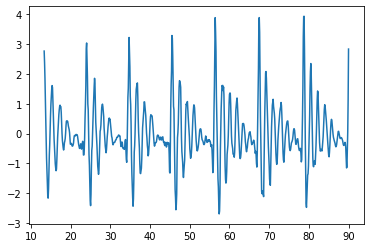

In [3]:
source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = False
)

vtfilter = filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    rand_triple(),
    source_config = source_config,
    vtfilter = vtfilter,
    #process_data_kwargs=dict(max_NP = 2, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

## Try VI with jax_advi

Gradients seem to work when `impose_null_integral = False`!!
But out of memory error mysteriously using pathfinder, so we try another vi.

In [9]:
import jax_advi
import jax.scipy

In [10]:
ndim = model.ndim(hyper)
print(ndim)
theta_bijector = model.theta_trajectory_bijector(hyper)

def logabsdet_delw_deltheta(w):
    return -theta_bijector.forward_log_det_jacobian(w)

def loglike(w):
    """Return L(theta(w)) where a priori w ~ N(0, I)"""
    theta = theta_bijector.forward(w)
    logcorrection = logabsdet_delw_deltheta(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood + logcorrection

def logprior(w):
    return jnp.sum(jax.scipy.stats.norm.logpdf(w))

def minus_inf_if_nan(x):
    return jax.lax.cond(jnp.isnan(x), lambda: -jnp.inf, lambda: x)

def logjoint(w):
    lj = loglike(w) + logprior(w)
    return minus_inf_if_nan(lj)

# Test our likelihood and joint functions: OK
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())

l1 = model.full_likelihood(theta, hyper) + prior.log_prob(theta)

#
w = theta_bijector.inverse(theta)
l2 = logjoint(w)

#
l1, l2

130
[Memory]480.1s, 8.0min  : Loading get_aplawd_training_pairs_subset...
[Memory]480.6s, 8.0min  : Loading posterior_of_fitted_lf_values...
[Memory]480.9s, 8.0min  : Loading run_nested...
[Memory]481.2s, 8.0min  : Loading get_aplawd_training_pairs_subset...
[Memory]487.8s, 8.1min  : Loading posterior_of_fitted_TFB_values...
[Memory]488.1s, 8.1min  : Loading run_nested...
[Memory]488.2s, 8.1min  : Loading get_vtrformants_training_data...
[Memory]505.9s, 8.4min  : Loading run_nested...
[Memory]506.7s, 8.4min  : Loading run_nested...
[Memory]507.5s, 8.5min  : Loading run_nested...
[Memory]508.3s, 8.5min  : Loading run_nested...
[Memory]508.4s, 8.5min  : Loading get_vtrformants_training_data...
[Memory]516.3s, 8.6min  : Loading posterior_of_fitted_lf_values...
[Memory]516.3s, 8.6min  : Loading run_nested...
[Memory]516.3s, 8.6min  : Loading posterior_of_fitted_TFB_values...
[Memory]516.4s, 8.6min  : Loading run_nested...


(DeviceArray(-9365.06435535, dtype=float64),
 DeviceArray(-9365.06435535, dtype=float64))

In [11]:
tmp = jax.grad(logjoint)(randn(ndim))
tmp

DeviceArray([ 2.79524666e+04, -1.08128289e+04, -2.50279353e+03,
             -3.94962900e+02, -3.52886116e+02, -3.07103483e+02,
             -2.41843222e+02, -2.08496844e+02, -5.67239580e+01,
             -4.74093876e+01, -1.05486255e+04, -1.75598368e+03,
             -1.43123615e+03, -1.23192355e+03, -1.05698532e+03,
             -9.08492723e+02, -1.90021310e+02, -1.49026440e+02,
              2.87644898e+03,  2.72767782e+03,  1.99835049e+03,
              1.99694793e+03,  2.07134075e+03,  1.81807631e+03,
              9.96691913e+02,  6.17705311e+02,  2.60139290e+02,
              5.13184254e+01,  4.10312059e+01,  1.22034471e+02,
              2.07424390e+01,  2.14840555e+01, -4.53959883e+00,
              6.56130876e+01,  4.95988283e+03,  3.11300702e+03,
              1.80065192e+03,  1.46771365e+03,  1.06876535e+03,
              6.53957984e+02,  3.40950866e+02,  9.89115011e+01,
             -3.17821747e+03, -1.87990070e+03, -1.08785224e+03,
             -9.71027127e+02, -7.5442562

In [13]:
import jax_advi.advi

theta_shapes = {'w': (ndim,)}

# Jitting happens inside
result = jax_advi.advi.optimize_advi_mean_field(
    theta_shapes,
    lambda theta: logprior(theta['w']),
    lambda theta: loglike(theta['w']),
    verbose=True,
    M=25,
    opt_method="L-BFGS-B" # This is faster and seems to be leap succesfully over early local minima
)

37663.05079595217 120805.20601107339
6207.54012362289 8716.547690338919
5554.731064248206 7612.471642442153
2746.824382334089 3017.944485618626
1902.3771843990464 1590.7638402280802
1409.158022205877 738.6007927945582
1197.0991331199593 356.12648791267287
1080.500202726668 185.3329368206169
1012.4187971145582 123.43530111976473
932.6079703295145 151.75624894346373
841.8164533700359 204.83529257946904
713.5395612417291 248.22896341391925
525.5852834556686 552.9270425811864
521.1164535990195 299.54291503730826
420.1384104211312 264.66483338411865
1300.5021695596681 2647.423674695817
336.4359027553101 218.92444830165388
261.5765442510915 134.79075563504534
232.6004162249034 248.99995498359576
208.99829192873574 118.98133297293128
191.75960519882094 87.76725899914184
166.95807929391532 101.15375130096875
189.70177491554392 147.42867307340723
149.52343443531626 78.18754598150126
139.49906053268023 134.72982767673867
108.73079532704499 87.28115578960197
90.29028621515762 72.9746111023088
68.

0	log L = 464.2684426534312	SNR [dB] = 24.56293227360423
1	log L = 477.0506187923239	SNR [dB] = 24.71087947550792
2	log L = 485.56421782243035	SNR [dB] = 24.86280336039151
3	log L = 419.2208170564244	SNR [dB] = 25.195928955702087
4	log L = 472.48695583899655	SNR [dB] = 24.63320247967143


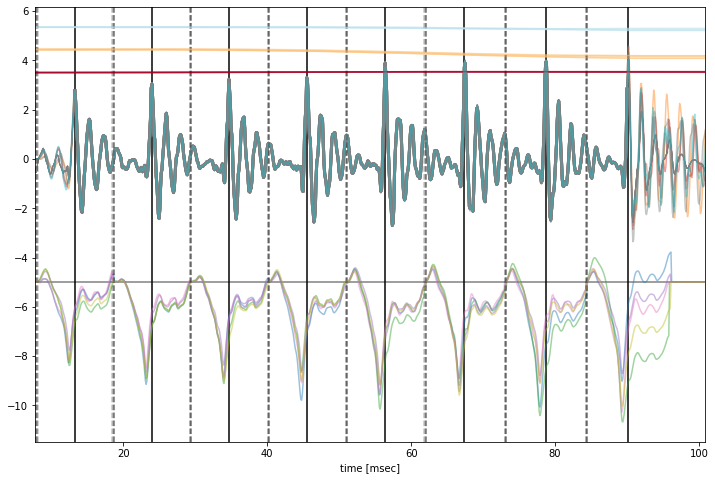

In [19]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 5

w_samples = result['draws']['w'][:nsamp,:]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

In [20]:
theta_source, theta_filter

({'Oq': DeviceArray([0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999], dtype=float64),
  'T': DeviceArray([10.61148484, 10.74564863, 10.81278987, 10.81230947,
               10.93301354, 11.09376233, 11.28293428, 11.66480677],            dtype=float64),
  'r': DeviceArray([0.02737532, 0.02566944, 0.0262098 , 0.02588339, 0.02474729,
               0.02736076, 0.02524154, 0.02588141], dtype=float64),
  'var_sigma': DeviceArray([0.51888572, 0.53660041, 0.55140038, 0.54553267, 0.5344136 ,
               0.59611729, 0.57039411, 0.61838793], dtype=float64)},
 {'g': DeviceArray([[ 2.94510121,  0.61080867,  0.2100238 ,  4.18102525,
                -1.16203238, -0.45667234],
               [ 3.26457061,  1.96510796, -1.06501709,  4.59607422,
                -3.32777743, -2.12820296],
               [ 4.94119636,  1.06249348, -1.88151999,  4.56173986,
                -3.80276192, -2.94971873],
               [ 2.98370656, -0.39790615, -0.12077228,  5.1122363 ,
                -3.32692697,

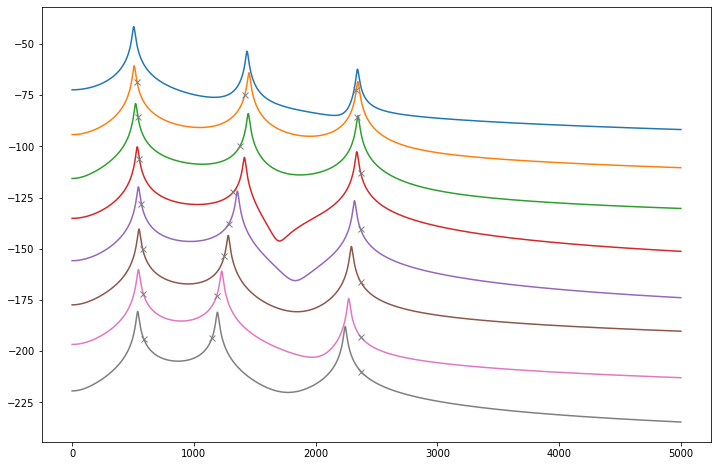

In [21]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

## Higher $K$